In [1]:
import os
import re
import timm
import sys
import numpy as np
import pandas as pd
from PIL import Image   
from tqdm import tqdm   

import torch
import torchvision.transforms as T
from torch import nn
# from torch.cuda import amp
from torch.amp import GradScaler, autocast

# from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
# This helps prevent OutOfMemoryError since big model stuff
torch.cuda.empty_cache()

#################################
# Set up some of the parameters #
#################################
MODEL_ID      = "ZoeD_N"
OUTPUT_DIR    = "zoedepth-finetuned"
ROOT_DIR      = ""
IMG_SIZE      = 256
BATCH_SIZE    = 2
LR            = 1e-4   # Keeping this kind of low on purpose
WEIGHT_DECAY  = 1e-4   # Our data is super clean and so we want to avoid overfitting
EPOCHS        = 20
SPLIT         = 0.1
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"
FREEZE        = True
MAX_DEPTH     = 10.0
PATIENCE      = 5
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# Logistic stuff and imports for model loading once we establish path stuff
os.makedirs(OUTPUT_DIR, exist_ok=True)
sys.path.append("ZoeDepth/") 
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config
print("Complete")

/home/jraubolt/.conda/envs/zoedepth/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Complete


In [2]:
####################
# Dataset handling # 
####################

# These are the transforms for the rgb and depth images
# Basically resizing the images to whatever we choose it to be 
# and normalize the images to be a PyTorch tensor  
# Basically make sure the data is still good after resizing and 
# is in a form that the model would expect 
rgb_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE), interpolation=T.InterpolationMode.BILINEAR), 
    T.ToTensor(), 
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

depth_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE),  interpolation=T.InterpolationMode.NEAREST), 
    T.Grayscale(num_output_channels=1),
    T.ToTensor()
])

# A class that handles loading the dataset such that each rgb image 
# is matched up with its corresponding depth map. The format for these
# is that it will be rgb_####.png and depth_####.png indicating they go
# together. 
# The folder structure is that all the rgb images are in one folder and 
# all the depth images are in another folder. So first we get the 
# images and its buddy. Then we apply the transforms that we previosuly 
# defined. Then we convert the depth tensor to be in the proper format. 
# As it is, it is just a 0-255 grayscale image but ZoeDepth needs it to be 
# a real world depth value (like in meters) and so we need to properly 
# rescale where the darker parts still indicate closer objects and the lighter
# parts indicate further objects, but on the proper scale. 
# This is all done in the getitem function which will return the rgb and 
# depth tensors
class DepthDataset(Dataset):
    # This class needs the root directory of the dataset and the transforms
    def __init__(self, root_dir, transform_rgb, transform_depth):
        self.rgb_dir = os.path.join(root_dir, "rgb")
        self.depth_dir = os.path.join(root_dir, "depth")
        self.rgb_files = sorted([f for f in os.listdir(self.rgb_dir) if f.endswith('.png')])

        self.transform_rgb = transform_rgb
        self.transform_depth = transform_depth

    def __len__(self):
        return len(self.rgb_files)

    # This is where all the action happens as explained above 
    def __getitem__(self, idx): 
        # Get the filenames for the rgb and depth images             
        rgb_filename = self.rgb_files[idx]
        depth_filename = rgb_filename.replace("rgb", "depth")

        # Get the full path of the images
        rgb_path = os.path.join(self.rgb_dir, rgb_filename)
        depth_path = os.path.join(self.depth_dir, depth_filename)
        
        # Open the images and make suer rgb is in proper format
        rgb_image = Image.open(rgb_path).convert('RGB')
        depth_image = Image.open(depth_path)

        # Apply the transforms
        rgb_tensor = self.transform_rgb(rgb_image)
        depth_tensor = self.transform_depth(depth_image).squeeze(0)

        # Apply the proper scaling for the depth tensor
        depth_tensor = depth_tensor * MAX_DEPTH  

        return {
            'rgb': rgb_tensor, 
            'depth': depth_tensor
        }

# Load the dataset 
dataset = DepthDataset(ROOT_DIR, rgb_transform, depth_transform)

# Handle splitting the dataset into training and validation and testing sets
total = len(dataset)
val_and_test_size = int(total * SPLIT)
train_size = total - val_and_test_size - val_and_test_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_and_test_size, val_and_test_size])

# Setup the dataloaders for training and validation and testing 
# Note that it is important that the training data get shuffled which is handled here
# Also some memory limitations so batch size has been pretty low
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Complete")

Complete


Number of training samples: 2400
Number of validation samples: 300
Number of testing samples: 300
Batch RGB shape: torch.Size([2, 3, 256, 256])
Batch Depth shape: torch.Size([2, 256, 256])


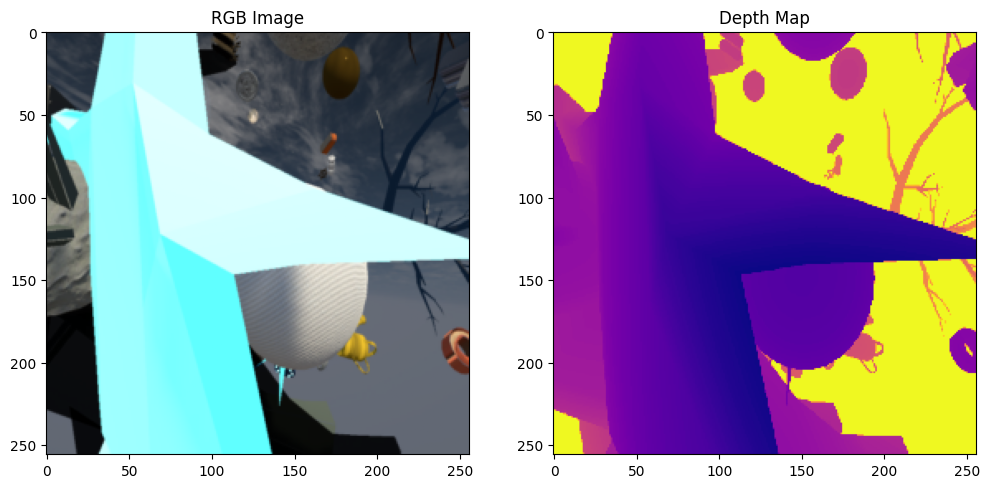

In [3]:
# Testing to make sure the data is being loaded properly and works and all
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
batch = next(iter(train_dataloader))
print("Batch RGB shape:", batch['rgb'].shape)
print("Batch Depth shape:", batch['depth'].shape)
import matplotlib.pyplot as plt
rgb_sample = batch['rgb'][0]
depth_sample = batch['depth'][0]
# So easier to visualize as a human 
mean = torch.tensor(IMAGENET_MEAN).view(3,1,1)
std = torch.tensor(IMAGENET_STD).view(3,1,1)
rgb_sample = rgb_sample * std + mean  # Unnormalize
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(rgb_sample.permute(1,2,0).cpu().numpy())
plt.title("RGB Image")
plt.subplot(1,2,2)
plt.imshow(depth_sample.cpu().numpy(), cmap='plasma')
plt.title("Depth Map")
plt.show()

In [4]:
######################################
# Loss function & Evaluation metrics #
######################################

# ZoeDepth uses this in their dictionary output, hence we must use 
KEY_OUTPUT = 'metric_depth'

# Basically be able to extract the prediction regardless of how 
# it was returned by model 
def extract_key(prediction, key):
    if isinstance(prediction, dict):
        return prediction[key]
    return prediction

# For our loss function we are using SILogLoss which is common for 
# depth prediction
class SILogLoss(nn.Module):
    # Default beta fo .15 for balanacing vairance and mean (bias), 
    # can be changed, we chose this to learn more on 
    # local consistency rather than overall bias 
    def __init__(self, beta=0.15):
        super(SILogLoss, self).__init__()
        self.beta = beta

    # Compute the loss function
    def forward(self, input, target, mask=None, interpolate=True):
        # Use the helper function to get the model output
        input = extract_key(input, KEY_OUTPUT)

        # Make sure the sizes match up and handle if not
        if input.shape[-2:] != target.shape[-2:] and interpolate:
            input = nn.functional.interpolate(
                input, size=target.shape[-2:], mode='bilinear', align_corners=True
            )

        # Make suer the target is the right dimension (1 channel)
        if target.ndim == 3:
            target = target.unsqueeze(1)

        # Handle mask consistency if needed 
        if mask is not None:
            if mask.ndim == 3:
                mask = mask.unsqueeze(1)
            input = input[mask.bool()]
            target = target[mask.bool()]

        # Disable AMP for stability since logs and sqrt can be sensitive 
        with torch.amp.autocast(device_type=DEVICE, enabled=False):  
            # Prevent negatives and 0s since we are doing logs
            eps = 1e-6
            input = input.clamp(min=eps)
            target = target.clamp(min=eps)

            # Do the math to compute the loss, basically we do the 
            # log-difference between the prediction and the ground truth 
            # 1. Get relative error between prediccted and ground truth on log scale
            g = torch.log(input) - torch.log(target)
            g = torch.nan_to_num(g, nan=0.0, posinf=1e6, neginf=-1e6) 
            # Get how spread out logs are with var and then bias with mean 
            Dg = torch.var(g) + self.beta * (torch.mean(g) ** 2)
            # Get back to og scale and multiply for our sake of not having to look at small numbers 
            loss = 10 * torch.sqrt(Dg + eps)  
        return loss

# Function to calculate our evaluation metrics 
# We are using:
# - d1: Percentage of pixels with relative error < 1.25 (accuracy)
# - abs_rel: Absolute relative error
# - rmse: Root mean square error (large errors big penalty)
# - mae: Mean absolute error (all errors get equal penalty)
# - silog: Scale-invariant log error (but for eval not loss function)
# These are all common metrics for depth estimation, which is why 
# we chose them 
def eval_depth(pred, target):
    assert pred.shape == target.shape

    # make sure positive and in range since we 
    # are doing logs and square roots and such 
    pred = pred.clamp(min=1e-3, max=MAX_DEPTH)
    target = target.clamp(min=1e-3, max=MAX_DEPTH)

    # Get how close prediction is to ground truth 
    # in a scale-invariance way 
    thresh = torch.max(target / pred, pred / target)

    # Do the various calculations for the metrics
    d1 = (thresh < 1.25).float().mean()
    diff = pred - target
    diff_log = torch.log(pred) - torch.log(target)
    abs_rel = torch.mean(torch.abs(diff) / target)
    rmse = torch.sqrt(torch.mean(diff ** 2))
    mae = torch.mean(torch.abs(diff))
    silog = torch.sqrt(diff_log.pow(2).mean() - 0.5 * diff_log.mean().pow(2))

    return {
        'd1': d1.detach(),
        'abs_rel': abs_rel.detach(),
        'rmse': rmse.detach(),
        'mae': mae.detach(),
        'silog': silog.detach()
    }

print("Complete")

Complete


In [5]:
##############
# Load model #
##############
# we cloned the repo and are manually adding it with their script 
# because torch hub was being a b*tch or we are just stupid 
# conf = get_config("zoedepth_nk", "infer")
conf = get_config("zoedepth", "train")
# conf = get_config("zoedepth", "train", config_version="kitti")
# conf = get_config("zoedepth_nk", "train")
model = build_model(conf)
model = model.to(DEVICE)

print("Model loaded successfully!")

# Our goal is to make the model more robust by adding the synthetic 
# random data, as such we don't want to risk our data causing the 
# pre-trained model to lose its good wweights and understaning 
# of scene features. To address this we freeze the encoder layers
# or like the backbone with the strong basic core and then we just 
# fine-tune the decoder. This is because we don't want to mess with 
# how the model extracts features (encoder), we want to mess with how 
# it predicts how far things are (decoder) 
if FREEZE:
    for name, param in model.named_parameters():
        if "backbone" in name:  # ZoeDepth uses "backbone" to name encoder layers
            param.requires_grad = False
    print("Backbone layers frozen.")

img_size [384, 512]


Using cache found in /home/jraubolt/.cache/torch/hub/intel-isl_MiDaS_master
/home/jraubolt/.conda/envs/zoedepth/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  32
	resize_method:  minimal
Model loaded successfully!
Backbone layers frozen.


In [6]:
#########################
# Optimizer & Scheduler #
#########################
# We are using AdamW optimizer becuase it is good
# for models like this using transformers and can 
# handle weight decay

# Outline how we want the model to learn and how fast we want it to learn 
# Again we don't want to deal with the frozen layers, and we handle that here
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = SILogLoss()

# Managing gpu and memory stuff
# scaler = GradScaler()
scaler = GradScaler(device=DEVICE)

# Keep track of the best model
best_val_absrel = float('inf')

print("Complete")

Complete


In [7]:
################################
# Training and Validating loop #
################################

# Track this stuff so I can plot later 
train_losses = []
val_metrics_log = {'d1': [], 'abs_rel': [], 'rmse': [], 'mae': [], 'silog': []}

# For early stopping
patience_counter = 0
prev_loss = float('inf')
actual_epochs = 0

# Finetuning time!
for epoch in range(1, EPOCHS + 1):
    # training mode 
    model.train()
    train_loss = 0.0
    actual_epochs += 1

    good_batches = 0

    # Go batch by batch, even though our batches are so small for memeory issues 
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch} Training"):
        # Get the images and depth maps ready 
        images = batch['rgb'].to(DEVICE)
        depths = batch['depth'].to(DEVICE)
        mask = (depths > 0.001) & (depths < MAX_DEPTH)

        # CLear previous gradients before backpropogation
        optimizer.zero_grad()

        # Get the predictions and compute the loss
        with autocast(device_type=DEVICE):
            outputs = model(images)
            loss = criterion(outputs, depths, mask=mask)

        if not torch.isfinite(loss):
            print(f"Warning: non-finite loss detected in batch. Skipping batch.")
            continue
    
        # Backpropogate the loss and update the parameters and such
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # Update the training loss 
        good_batches += 1
        train_loss += loss.item()

    # Needs to be at the end of each epoch not each batch 
    scheduler.step()

    # Average the training loss over the entire epoch
    train_loss /= good_batches

    # Validation and print results 
    model.eval()
    val_metrics = {'d1': 0, 'abs_rel': 0, 'rmse': 0, 'mae': 0, 'silog': 0}

    # Now we go through the validation set to see how are model is doing
    # No need to work with gradients since its validation and don't want 
    # to be wasting that mem
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Epoch {epoch} Validation"):
            # Load the images and get the predictions
            images = batch['rgb'].to(DEVICE)
            depths = batch['depth'].to(DEVICE)
            outputs = model(images)
            preds = extract_key(outputs, KEY_OUTPUT).squeeze(1) * MAX_DEPTH

            # Resizing stuff if needed 
            preds = nn.functional.interpolate(
                preds.unsqueeze(1), size=depths.shape[-2:], mode='bilinear', align_corners=True
            ).squeeze(1)

            # Get the metrics for this batch
            mask = (depths > 0.001) & (depths < MAX_DEPTH)
            cur_metrics = eval_depth(preds[mask], depths[mask])

            # Accumulate the metrics
            for k in val_metrics.keys():
                val_metrics[k] += cur_metrics[k]

    # Average the validation metrics over the entire epoch
    for k in val_metrics.keys():
        val_metrics[k] /= len(val_dataloader)

    # Update the training loss and validation metrics for printing later
    train_losses.append(train_loss)
    for k in val_metrics.keys():
        val_metrics_log[k].append(val_metrics[k].item())

    # Print the results for this epoch
    # print(f"Epoch {epoch}: Train Loss = {train_loss:.5f} | Val Metrics = { {k: round(v.item(), 5) for k, v in val_metrics.items()} }")
    print("="*30)
    print(f"Epoch {epoch}")
    print(f"Train Loss: {train_loss:.5f}")
    print("Validation Metrics:")
    for k, v in val_metrics.items():
        print(f"  - {k}: {v.item():.5f}")
    print("="*30)

    # Save the model if it gets better and if it doesn't get better
    # then we want to update the earlystopping mechanism to stop training when needed
    if train_loss < prev_loss:
        prev_loss = train_loss
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_model.pth"))
        print(f"New best model saved at epoch {epoch} with train_loss = {train_loss:.5f}")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement in train_loss for {patience_counter} epoch(s).")
    
        if patience_counter >= PATIENCE:
            print(f"Early stopping triggered after {epoch} epochs!")
            break

Epoch 1 Validation: 100%|██████████| 150/150 [00:38<00:00,  3.87it/s]


Epoch 1
Train Loss: 3.29277
Validation Metrics:
  - d1: 0.01573
  - abs_rel: 1.35317
  - rmse: 5.48890
  - mae: 5.33175
  - silog: 0.63493
New best model saved at epoch 1 with train_loss = 3.29277


Epoch 2 Validation: 100%|██████████| 150/150 [00:38<00:00,  3.93it/s]


Epoch 2
Train Loss: 2.46933
Validation Metrics:
  - d1: 0.01573
  - abs_rel: 1.35317
  - rmse: 5.48890
  - mae: 5.33175
  - silog: 0.63493
New best model saved at epoch 2 with train_loss = 2.46933


Epoch 3 Validation: 100%|██████████| 150/150 [00:38<00:00,  3.93it/s]


Epoch 3
Train Loss: 2.28135
Validation Metrics:
  - d1: 0.01573
  - abs_rel: 1.35317
  - rmse: 5.48890
  - mae: 5.33175
  - silog: 0.63493
New best model saved at epoch 3 with train_loss = 2.28135


Epoch 4 Validation: 100%|██████████| 150/150 [00:38<00:00,  3.93it/s]


Epoch 4
Train Loss: 2.09563
Validation Metrics:
  - d1: 0.01573
  - abs_rel: 1.35317
  - rmse: 5.48890
  - mae: 5.33175
  - silog: 0.63493
New best model saved at epoch 4 with train_loss = 2.09563


Epoch 5 Validation: 100%|██████████| 150/150 [00:38<00:00,  3.93it/s]


Epoch 5
Train Loss: 1.91046
Validation Metrics:
  - d1: 0.01573
  - abs_rel: 1.35317
  - rmse: 5.48890
  - mae: 5.33175
  - silog: 0.63493
New best model saved at epoch 5 with train_loss = 1.91046


Epoch 6 Validation: 100%|██████████| 150/150 [00:38<00:00,  3.93it/s]


Epoch 6
Train Loss: 1.76063
Validation Metrics:
  - d1: 0.01573
  - abs_rel: 1.35317
  - rmse: 5.48890
  - mae: 5.33175
  - silog: 0.63493
New best model saved at epoch 6 with train_loss = 1.76063


Epoch 7 Validation: 100%|██████████| 150/150 [00:38<00:00,  3.93it/s]


Epoch 7
Train Loss: 1.61744
Validation Metrics:
  - d1: 0.01573
  - abs_rel: 1.35317
  - rmse: 5.48890
  - mae: 5.33175
  - silog: 0.63493
New best model saved at epoch 7 with train_loss = 1.61744


Epoch 8 Validation: 100%|██████████| 150/150 [00:38<00:00,  3.93it/s]


Epoch 8
Train Loss: 1.35120
Validation Metrics:
  - d1: 0.01573
  - abs_rel: 1.35317
  - rmse: 5.48890
  - mae: 5.33175
  - silog: 0.63493
New best model saved at epoch 8 with train_loss = 1.35120


Epoch 9 Validation: 100%|██████████| 150/150 [00:38<00:00,  3.94it/s]


Epoch 9
Train Loss: 0.55611
Validation Metrics:
  - d1: 0.01573
  - abs_rel: 1.35317
  - rmse: 5.48890
  - mae: 5.33175
  - silog: 0.63493
New best model saved at epoch 9 with train_loss = 0.55611


Epoch 10 Validation: 100%|██████████| 150/150 [00:38<00:00,  3.94it/s]


Epoch 10
Train Loss: 0.55454
Validation Metrics:
  - d1: 0.01573
  - abs_rel: 1.35317
  - rmse: 5.48890
  - mae: 5.33175
  - silog: 0.63493
New best model saved at epoch 10 with train_loss = 0.55454


Epoch 11 Validation: 100%|██████████| 150/150 [00:38<00:00,  3.93it/s]


Epoch 11
Train Loss: 0.55495
Validation Metrics:
  - d1: 0.01573
  - abs_rel: 1.35317
  - rmse: 5.48890
  - mae: 5.33175
  - silog: 0.63493
No improvement in train_loss for 1 epoch(s).


Epoch 12 Validation: 100%|██████████| 150/150 [00:38<00:00,  3.94it/s]


Epoch 12
Train Loss: 0.55501
Validation Metrics:
  - d1: 0.01573
  - abs_rel: 1.35317
  - rmse: 5.48890
  - mae: 5.33175
  - silog: 0.63493
No improvement in train_loss for 2 epoch(s).


Epoch 13 Validation: 100%|██████████| 150/150 [00:38<00:00,  3.93it/s]


Epoch 13
Train Loss: 0.55670
Validation Metrics:
  - d1: 0.01573
  - abs_rel: 1.35317
  - rmse: 5.48890
  - mae: 5.33175
  - silog: 0.63493
No improvement in train_loss for 3 epoch(s).


Epoch 14 Validation: 100%|██████████| 150/150 [00:38<00:00,  3.94it/s]


Epoch 14
Train Loss: 0.55634
Validation Metrics:
  - d1: 0.01573
  - abs_rel: 1.35317
  - rmse: 5.48890
  - mae: 5.33175
  - silog: 0.63493
No improvement in train_loss for 4 epoch(s).


Epoch 15 Validation: 100%|██████████| 150/150 [00:38<00:00,  3.93it/s]

Epoch 15
Train Loss: 0.55584
Validation Metrics:
  - d1: 0.01573
  - abs_rel: 1.35317
  - rmse: 5.48890
  - mae: 5.33175
  - silog: 0.63493
No improvement in train_loss for 5 epoch(s).
Early stopping triggered after 15 epochs!


In [8]:
####################
# Save final model #
####################
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "final_model.pth"))
print("Training complete, woohoo.")


Training complete, woohoo.


In [9]:
########################
# Evaluate on test set #
########################
model.eval()
test_metrics = {'d1': 0, 'abs_rel': 0, 'rmse': 0, 'mae': 0, 'silog': 0}

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        images = batch['rgb'].to(DEVICE)
        depths = batch['depth'].to(DEVICE)

        outputs = model(images)
        preds = extract_key(outputs, KEY_OUTPUT).squeeze(1) * MAX_DEPTH
        preds = nn.functional.interpolate(
            preds.unsqueeze(1), size=depths.shape[-2:], mode='bilinear', align_corners=True
        ).squeeze(1)

        mask = (depths > 0.001) & (depths < MAX_DEPTH)
        cur_metrics = eval_depth(preds[mask], depths[mask])

        for k in test_metrics.keys():
            test_metrics[k] += cur_metrics[k]

# Average
for k in test_metrics.keys():
    test_metrics[k] /= len(test_dataloader)

# Print final test metrics
print("="*30)
print("Test Set Evaluation")
for k, v in test_metrics.items():
    print(f"  - {k}: {v.item():.5f}")
print("="*30)

Testing: 100%|██████████| 150/150 [00:37<00:00,  3.96it/s]

Test Set Evaluation
  - d1: 0.01623
  - abs_rel: 1.34804
  - rmse: 5.47930
  - mae: 5.31770
  - silog: 0.63528


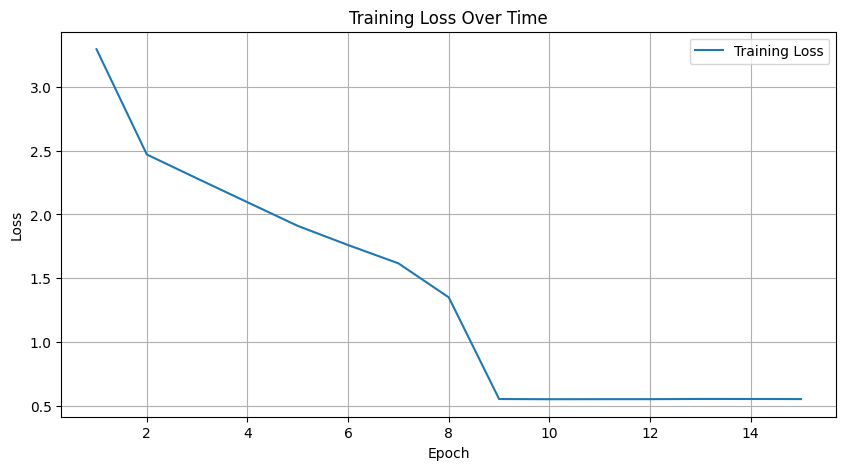

In [11]:
#####################################################
# Plotting the training loss and validation metrics #
#####################################################
epochs = list(range(1, actual_epochs + 1))

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, "training_loss_curve.png"))
plt.show()

# Save training and testing details to csv
# Build the DataFrame and save it and whatnot
data = {
    'epoch': list(range(1, actual_epochs + 1)),
    'train_loss': train_losses
}
for metric_name, values in val_metrics_log.items():
    data[f'val_{metric_name}'] = values
df = pd.DataFrame(data)
csv_path = os.path.join(OUTPUT_DIR, "training_log.csv")
df.to_csv(csv_path, index=False)

test_metrics_df = pd.DataFrame({k: [v.item()] for k, v in test_metrics.items()})
test_metrics_df.to_csv(os.path.join(OUTPUT_DIR, "test_metrics.csv"), index=False)




In [13]:
############################
# Load og model and test it#
############################

# Load the original model
conf = get_config("zoedepth", "infer")
og_model = build_model(conf)
og_model = og_model.to(DEVICE)

print("Original model loaded successfully!")
initial_og_metrics = {'d1': 0, 'abs_rel': 0, 'rmse': 0, 'mae': 0, 'silog': 0}

# Put it in eval mode and test it on the test data
# This is the same process as before 
og_model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating Pre-Finetuning Model"):
        images = batch['rgb'].to(DEVICE)
        depths = batch['depth'].to(DEVICE)

        outputs = og_model(images)
        preds = extract_key(outputs, KEY_OUTPUT).squeeze(1) * MAX_DEPTH

        preds = nn.functional.interpolate(
            preds.unsqueeze(1), size=depths.shape[-2:], mode='bilinear', align_corners=True
        ).squeeze(1)

        mask = (depths > 0.001) & (depths < MAX_DEPTH)
        cur_metrics = eval_depth(preds[mask], depths[mask])

        for k in initial_og_metrics.keys():
            initial_og_metrics[k] += cur_metrics[k]

for k in initial_og_metrics.keys():
    initial_og_metrics[k] /= len(test_dataloader)

print("="*30)
print("Pre-Finetued Model Metrics:")
for k, v in initial_og_metrics.items():
    print(f"  - {k}: {v.item():.5f}")
print("="*30)

img_size [384, 512]


Using cache found in /home/jraubolt/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully
Original model loaded successfully!


Evaluating Pre-Finetuning Model: 100%|██████████| 150/150 [00:27<00:00,  5.50it/s]

Pre-Finetued Model Metrics:
  - d1: 0.01624
  - abs_rel: 1.34799
  - rmse: 5.47911
  - mae: 5.31749
  - silog: 0.63526


In [18]:
###################
# Compare resutls #
###################
from tabulate import tabulate

comparison = []
for metric in test_metrics.keys():
    pre = initial_og_metrics[metric].item() if torch.is_tensor(initial_og_metrics[metric]) else initial_og_metrics[metric]
    post = test_metrics[metric].item() if torch.is_tensor(test_metrics[metric]) else test_metrics[metric]
    delta = pre - post
    comparison.append([metric, f"{pre:.5f}", f"{post:.5f}", f"{delta:+.5f}"])

# Print a nice table
headers = ["Metric", "Pre-Finetune", "Post-Finetune", "Improvement"]
print(tabulate(comparison, headers=headers, tablefmt="fancy_grid"))

╒══════════╤════════════════╤═════════════════╤═══════════════╕
│ Metric   │   Pre-Finetune │   Post-Finetune │   Improvement │
╞══════════╪════════════════╪═════════════════╪═══════════════╡
│ d1       │        0.01624 │         0.01623 │       0       │
├──────────┼────────────────┼─────────────────┼───────────────┤
│ abs_rel  │        1.34799 │         1.34804 │      -5e-05   │
├──────────┼────────────────┼─────────────────┼───────────────┤
│ rmse     │        5.47911 │         5.4793  │      -0.00019 │
├──────────┼────────────────┼─────────────────┼───────────────┤
│ mae      │        5.31749 │         5.3177  │      -0.0002  │
├──────────┼────────────────┼─────────────────┼───────────────┤
│ silog    │        0.63526 │         0.63528 │      -1e-05   │
╘══════════╧════════════════╧═════════════════╧═══════════════╛


In [19]:
def visualize_predictions(model, dataloader, num_samples=5):
    model.eval()
    count = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch['rgb'].to(DEVICE)
            depths = batch['depth'].to(DEVICE)

            # Get predictions
            outputs = model(images)
            preds = extract_key(outputs, KEY_OUTPUT).squeeze(1) * MAX_DEPTH
            preds = nn.functional.interpolate(
                preds.unsqueeze(1), size=depths.shape[-2:], mode='bilinear', align_corners=True
            ).squeeze(1)

            for i in range(images.size(0)):
                if count >= num_samples:
                    return
                # Unnormalize RGB
                img = images[i].cpu()
                mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
                std = torch.tensor(IMAGENET_STD).view(3, 1, 1)
                img = img * std + mean
                img = img.permute(1, 2, 0).numpy()

                # Depths and predictions
                gt = depths[i].cpu().numpy()
                pred = preds[i].cpu().numpy()

                # Plot
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(img)
                plt.title("RGB Image")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(gt, cmap="plasma")
                plt.title("Ground Truth Depth")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(pred, cmap="plasma")
                plt.title("Predicted Depth")
                plt.axis("off")

                plt.show()
                count += 1

Finetuned model:


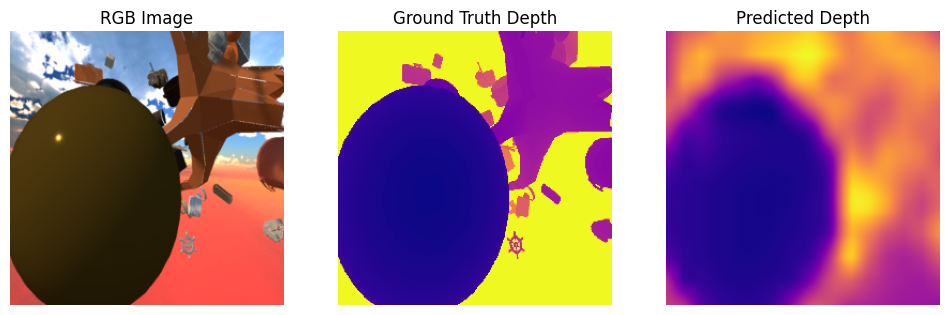

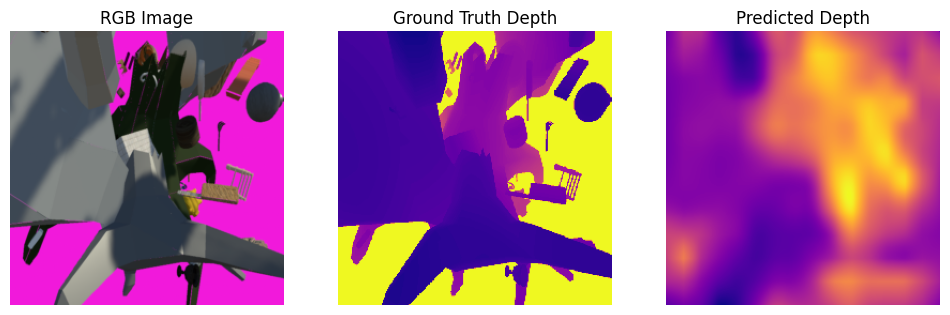

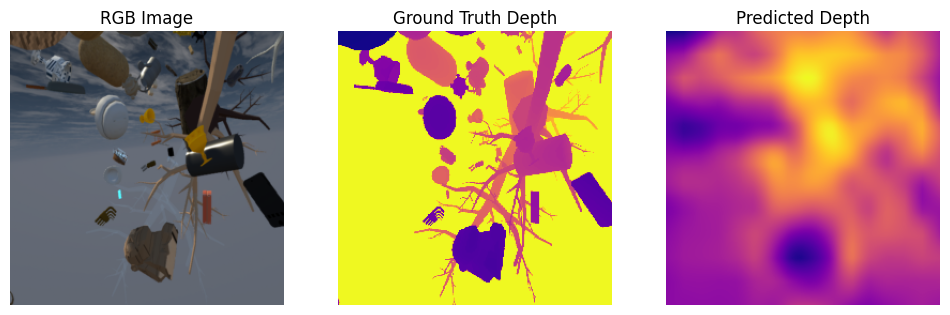

Original model:


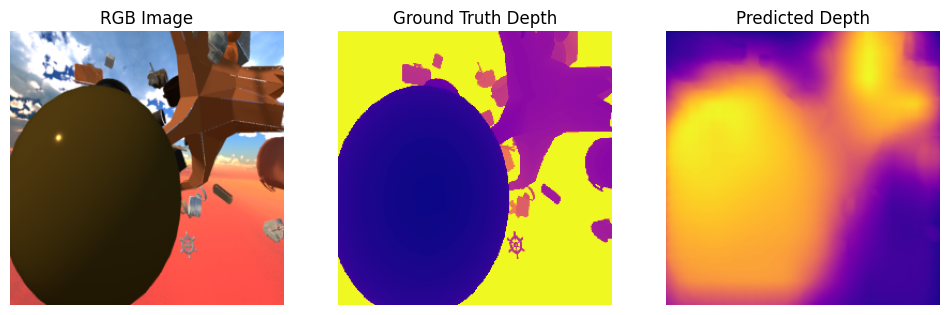

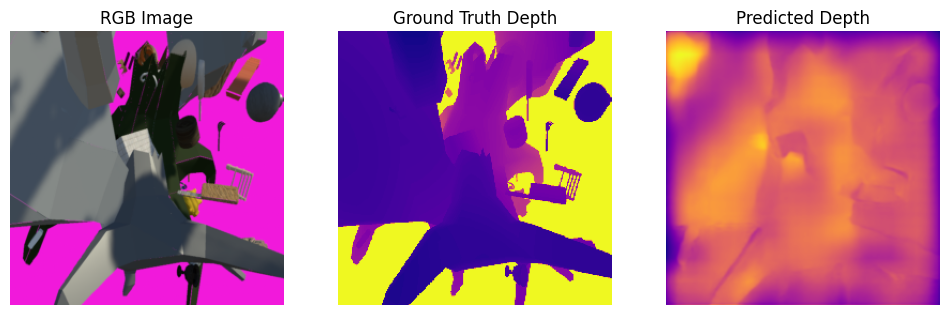

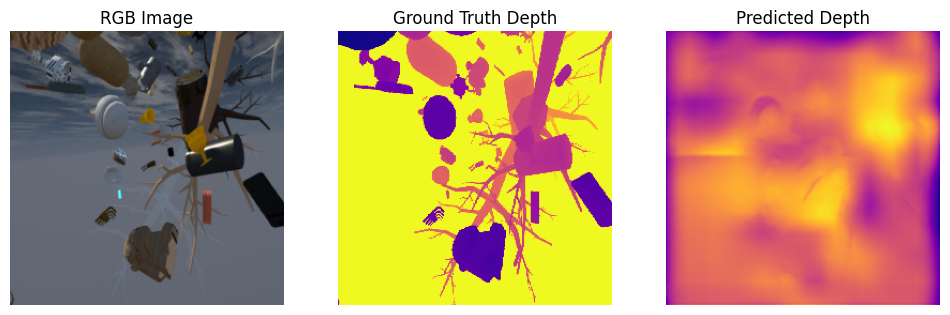

In [21]:
print("Finetuned model:")
visualize_predictions(model, test_dataloader, num_samples=3)
print("Original model:")
visualize_predictions(og_model, test_dataloader, num_samples=3)
